# Predict Future Values of Emissions

In [71]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import json
import random
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras import backend as K

## Read Data

In [72]:
# Read in emission data
emission_input = pd.read_csv('../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_input['Total_CO2_Emission'].values
emission_data = emission_data[0:len(emission_data)-6]
emission_data = emission_data.astype('float64')
emission_index = emission_input['date'].values
# Take only the emissions on which we have indicators
print(f"Shape output data: {emission_data.shape}")
#print(emission_index)


Shape output data: (366,)


In [74]:
data= pd.Series(emission_data)
first_date = emission_index[0]
last_date = emission_index[-1]
split_train = np.arange(0, len(data)-12)
split_test = np.arange((len(data)-12), len(data))
train_data = pd.Series(data, index=split_train)
test_data = pd.Series(data, index=split_test)
time_scope = emission_index

# Auto Sarima Model

In [75]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,12) [intercept=True]; AIC=710.594, BIC=729.768, Time=2.995 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=1385.064, BIC=1392.733, Time=0.056 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=750.042, BIC=765.382, Time=1.524 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=1057.452, BIC=1072.791, Time=1.281 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=1455.623, BIC=1459.458, Time=0.048 seconds
Fit ARIMA(1,0,1)x(0,1,0,12) [intercept=True]; AIC=935.748, BIC=951.087, Time=0.243 seconds
Fit ARIMA(1,0,1)x(1,1,1,12) [intercept=True]; AIC=685.687, BIC=708.696, Time=3.901 seconds
Fit ARIMA(1,0,1)x(1,1,0,12) [intercept=True]; AIC=751.923, BIC=771.097, Time=1.886 seconds
Fit ARIMA(1,0,1)x(2,1,1,12) [intercept=True]; AIC=687.471, BIC=714.315, Time=10.583 seconds
Fit ARIMA(1,0,1)x(1,1,2,12) [intercept=True]; AIC=687.465, BIC=714.309, Time=9.399 seconds
Fit ARIMA(1,0,1)x(0,1,2,12) [intercept=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  354
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -337.535
Date:                              Mon, 10 Aug 2020   AIC                            685.070
Time:                                      20:02:21   BIC                            704.244
Sample:                                           0   HQIC                           692.708
                                              - 354                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0430      0.030     -1.441      0.149      -0.101       0.015
ar.L1          0.9627      0.018     52.644      0.000       0.927       0.999
ar.S.L12      -0.3165      0.028    -11.379      0.000      -0.371      -0.262
ma.S.L12      -0.7349      0.034    -21.678      0.000      -0.801      -0.668
sigma2         0.4015      0.010     38.463      0.000       0.381       0.422
===================================================================================
Ljung-Box (Q):                       47.09   Jarque-Bera (JB):              8152.00
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.33
Prob(H) (two-sided):                  0.27   Kurtosis:                        26.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

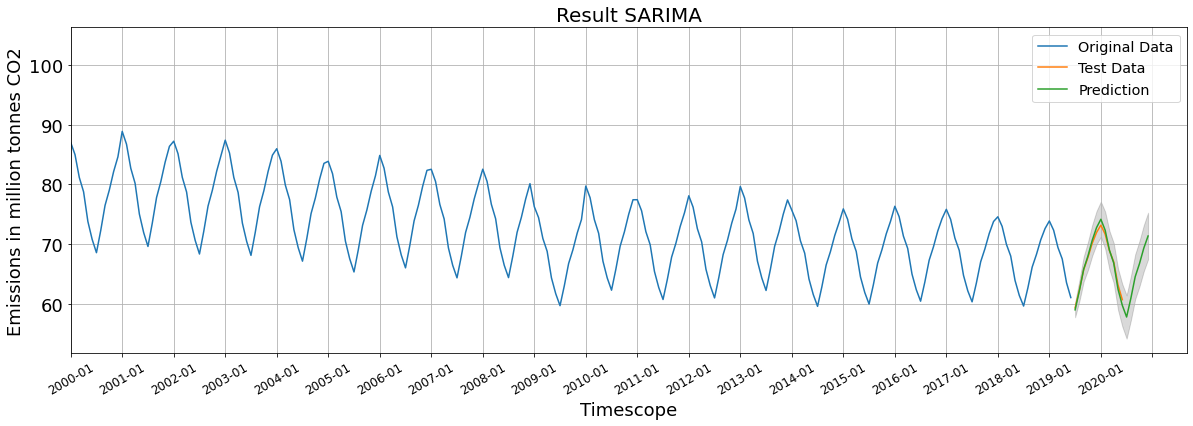

In [76]:
# Forecast
#to get accuracy predict last year as well
n_periods = 18
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
#index_of_fc = np.arange(len(data)-12, len(data)-12+n_periods)

index_of_fc = np.arange(len(data)-12, len(data)-12+n_periods)
index_of_test = np.arange(len(data)-12, len(data))
index_of_compare = np.arange(0,6)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
test_series = pd.Series(test_data, index=index_of_test)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
sarima_array = fitted[-7:-1]
sarima_compare = pd.Series(sarima_array, index=index_of_compare)

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(train_data, label='Original Data')
line3 = plt.plot(test_series, label='Test Data')
line2 = plt.plot(fitted_series, label='Prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(len(time_scope)+1)[::12], time_scope[::12], rotation=30, fontsize=12)
#plt.xticks(np.arange(len(time_scope)), time_scope, rotation=30)
plt.xlim([120,380])
plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Result SARIMA", fontsize=20)

plt.show()

In [77]:
# Accuracy metrics
fitted = fitted[0:12]
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print("Accuracy of the model:")
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
forecast_accuracy(fitted, test_data)

Accuracy of the model:


{'mape': 0.007037505139794171,
 'me': 0.08894873886469057,
 'mae': 0.4726882483910882,
 'mpe': 0.000828340691553468,
 'rmse': 0.5740652353976862,
 'corr': 0.9986976708273446,
 'minmax': 0.00699944624918869}

## MLP Model

In [78]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	# Shuffle windows
	if shuffle is True:
		dataX, dataY = shuffle(dataX, dataY, random_state=0)
	return np.array(dataX), np.array(dataY)

In [79]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [80]:
scaler = StandardScaler()
#emission_data = scaler.fit_transform(emission_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8
shuffle = True

# Split into train and test sets
train_size = int(len(emission_data) * split_ratio)
test_size = len(emission_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

In [89]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
    model = Sequential()
    # Flatten array if input is matrix
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(look_back, input_dim=trainX.shape[2]*look_back, activation='relu'))
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=2, callbacks=[es])
    model.summary()
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [90]:
# Emissions as input
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [91]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(274, 12)
(274, 6)
(56, 12)
(56, 6)


### Train Model

In [92]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY, look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/100
137/137 - 0s - loss: 962.1526
Epoch 2/100
137/137 - 0s - loss: 52.6295
Epoch 3/100
137/137 - 0s - loss: 39.7599
Epoch 4/100
137/137 - 0s - loss: 36.1929
Epoch 5/100
137/137 - 0s - loss: 31.6894
Epoch 6/100
137/137 - 0s - loss: 29.3641
Epoch 7/100
137/137 - 0s - loss: 25.7524
Epoch 8/100
137/137 - 0s - loss: 23.3784
Epoch 9/100
137/137 - 0s - loss: 21.1299
Epoch 10/100
137/137 - 0s - loss: 18.6301
Epoch 11/100
137/137 - 0s - loss: 16.6474
Epoch 12/100
137/137 - 0s - loss: 15.2237
Epoch 13/100
137/137 - 0s - loss: 13.2212
Epoch 14/100
137/137 - 0s - loss: 12.0215
Epoch 15/100
137/137 - 0s - loss: 10.6807
Epoch 16/100
137/137 - 0s - loss: 9.5918
Epoch 17/100
137/137 - 0s - loss: 8.4037
Epoch 18/100
137/137 - 0s - loss: 7.6624
Epoch 19/100
137/137 - 0s - loss: 7.5519
Epoch 20/100
137/137 - 0s - loss: 6.8118
Epoch 21/100
137/137 - 0s - loss: 6.5909
Epoch 22/100
137/137 - 0s - loss: 6.6814
Epoch 23/100
137/137 - 0s - loss: 6.2580
Epoch 24/100
137/137 - 0s - loss: 5.7830
Epoch 25/

137/137 - 0s - loss: 4.2970
Epoch 53/100
137/137 - 0s - loss: 4.6234
Epoch 54/100
137/137 - 0s - loss: 4.4043
Epoch 55/100
137/137 - 0s - loss: 4.5627
Epoch 56/100
137/137 - 0s - loss: 4.9150
Epoch 57/100
137/137 - 0s - loss: 4.6449
Epoch 58/100
137/137 - 0s - loss: 4.8004
Epoch 59/100
137/137 - 0s - loss: 4.3049
Epoch 60/100
137/137 - 0s - loss: 3.9984
Epoch 61/100
137/137 - 0s - loss: 4.3356
Epoch 62/100
137/137 - 0s - loss: 4.1757
Epoch 63/100
137/137 - 0s - loss: 4.4652
Epoch 64/100
137/137 - 0s - loss: 4.5313
Epoch 65/100
137/137 - 0s - loss: 4.4403
Epoch 66/100
137/137 - 0s - loss: 4.6918
Epoch 67/100
137/137 - 0s - loss: 4.3599
Epoch 68/100
137/137 - 0s - loss: 4.5195
Epoch 69/100
137/137 - 0s - loss: 4.3751
Epoch 70/100
137/137 - 0s - loss: 4.1662
Epoch 71/100
137/137 - 0s - loss: 4.0261
Epoch 72/100
137/137 - 0s - loss: 4.1324
Epoch 73/100
137/137 - 0s - loss: 4.4668
Epoch 74/100
137/137 - 0s - loss: 4.2263
Epoch 75/100
137/137 - 0s - loss: 4.1066
Epoch 76/100
137/137 - 0s - l

Train Score: 4.21 MSE (2.05 RMSE)
Test Score: 2.10 MSE (1.45 RMSE)


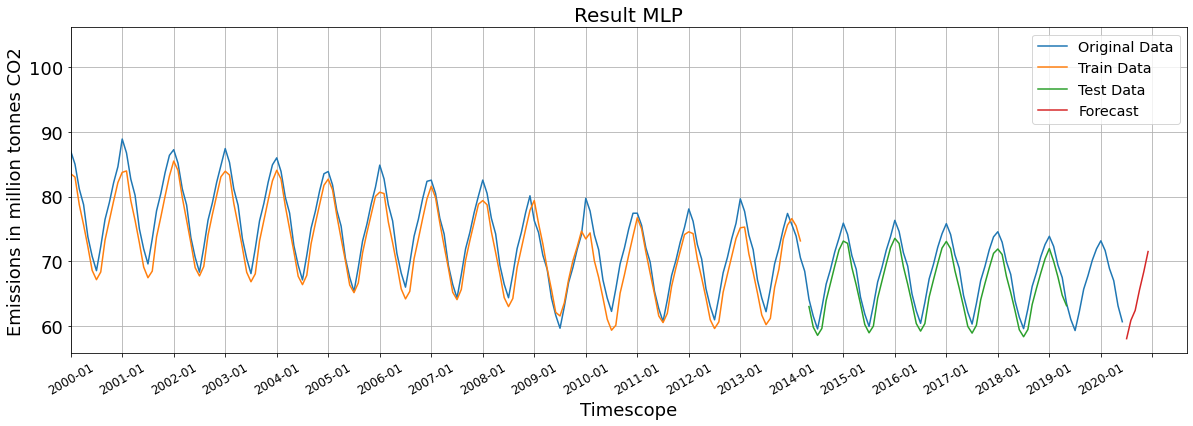

In [85]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan
mlp_compare = np.zeros(6)

X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]
mlp_compare[0:6] = predict[:]

# Plot baseline, training, test and forecast
plt.figure(figsize=(20,6))
line1 = plt.plot(emission_data[:], label='Original Data')
line3 = plt.plot(trainPredictPlot[:], label='Train Data')
line2 = plt.plot(testPredictPlot[:], label='Test Data')
line4 = plt.plot(forecastPlot[:], label='Forecast')

plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(len(time_scope)+1)[::12], time_scope[::12], rotation=30, fontsize=12)
plt.xlim([120,380])
plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Result MLP", fontsize=20)
plt.show()

#plt.xticks(np.arange(len(time_scope)), time_scope, rotation=30)


## Compare SARIMA with MLP

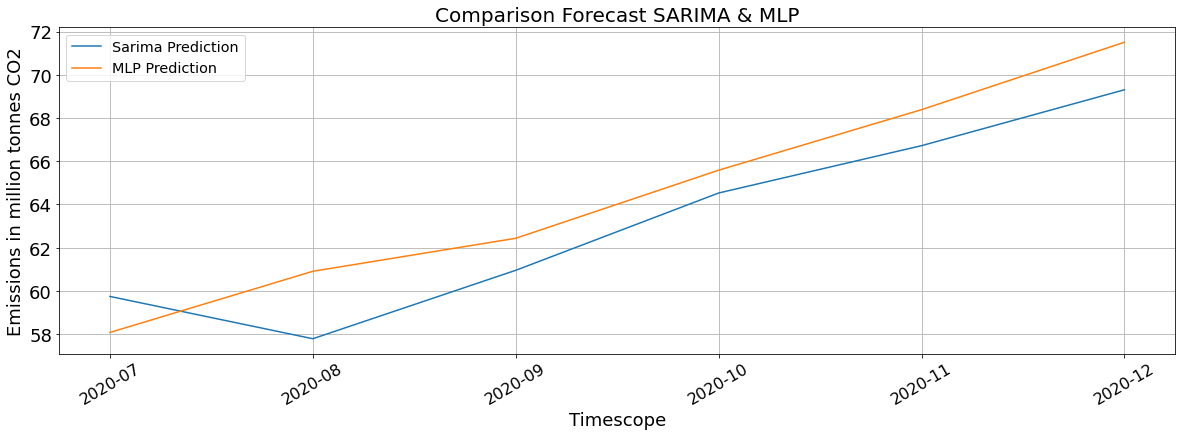

In [88]:
#sarima_plot = fitted[-7:-1]
#mlp_plot[0:horizon] = predict[:]
#sarima_plot = fitted_series[-7:-1] 


#plot difference between the forecasts
plt.figure(figsize=(20,6))
line1 = plt.plot(sarima_compare, label='Sarima Prediction')
line2 = plt.plot(mlp_compare, label='MLP Prediction')

plt.legend(fontsize='x-large')
plt.grid()
plt.xticks(np.arange(6), ['2020-07','2020-08', '2020-09', '2020-10', '2020-11', '2020-12'], rotation=30, fontsize=16)



plt.xlabel("Timescope", fontsize=18)
plt.ylabel("Emissions in million tonnes CO2", fontsize=18)
plt.yticks(fontsize=18)
plt.title("Comparison Forecast SARIMA & MLP", fontsize=20)
plt.show()
